# Cutting pattern
Extracting diffraction orders from Echelle spectrometer spectral image of an incandescent lamp.

## imports

In [1]:
%matplotlib inline

In [2]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import peakutils

# Generate test image
A typical Echelle spectrometer image with several diffraction orders.
Each diffraction order is a band with a parabolic shape.
Intensity for each order has a maximum in the center. 
With increasing diffraction order number, the intensity usually decreases.
Spacing between orders, their shape will depend on the set-up.
The synthetic image is helpful to demonstrate the extraction procedure of the diffraction orders.

In [3]:
def gf(x,*arg):
    """ Gaussian shape """
    A,c,s = arg
    return A*np.exp(-((x-c)/s)**2)

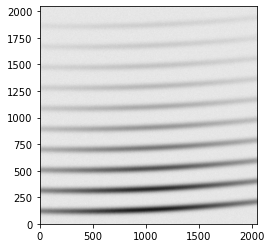

In [4]:
# image size in pixels
nx, ny = [2048, 2048]
image = np.zeros([nx, ny])

# generating order pattern
x = np.arange(nx)
pt = np.array([(3e-5 * (x - 300 - i ** 2) ** 2 + 120 + i * 193) for i in range(10)]).astype(int)

# Add Gaussiang profiles along the generated order lines
width = 200
profy = np.linspace(0, 2, width)

# Add intensity attenuation
intensity = 1 / ((x - nx / 2) ** 2 + 1e6)
intensity = intensity / intensity.max()
xx = np.arange(10)
vv = 1 / ((xx - 0.1) ** 2 + 10)
vv = vv / vv.max() * 20

# Add bands
for j, p in enumerate(pt):
    for i, y in enumerate(p):
        image[y - width // 2 : y + width // 2 + width % 2, i] = gf(profy, vv[j] * intensity[i], 1, 0.3)

# Add noise
image += np.random.rand(nx, ny) * 5
scale = 1
plt.imshow(image, origin="lower", cmap="binary")  # norm=mpl.colors.LogNorm(image.min(), image.max() * scale))

# Extract peak positions

## Check signal, select amplifier
Because intensity for higher orders may drop significantly, for best peak detection
it is better to amplify weak intensitys. Here, select this `amplifier` function.

### Smooth signal

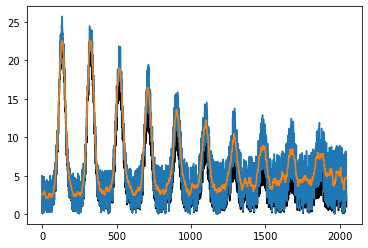

In [5]:
x = np.arange(nx)
y=image[:,1000]
ysm = savgol_filter(y,21,1)
amp = np.exp(3e-4*x) # amplify weak signal for higher orders
plt.plot(y,'k')
plt.plot(y*amp)
plt.plot(ysm*amp)

### Check

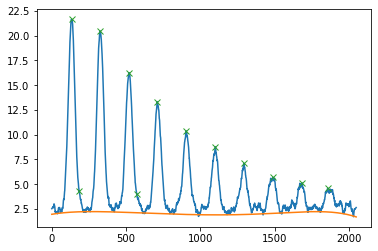

In [6]:
# calculate baseline
base = peakutils.baseline(ysm,6)
# Adjust parameters for correct peak detection
ind = peakutils.indexes(ysm-base, thres =.1, min_dist = 50)
plt.plot(ysm)
plt.plot(base)
plt.plot(ind,ysm[ind],'x')

## Peak positions over image

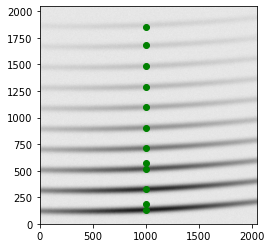

In [7]:
plt.imshow(image, origin="lower", cmap="binary")  # norm=mpl.colors.LogNorm(image.min(), image.max() * scale))
x = np.ones(ind.shape[0])*1000
plt.plot(x,ind,'og')

## Detect all and plot

Define positions for peak selection. Even distribution from center, which is the brightest.

If not all peaks are detected incorrectly, there will be different number of results for each `x` pixel in `xselec`.
If so, no fitting is done. Adjust peak finding parameters `thres` and `min_dist` to get all peaks, and no extra.

Shape's good!
But check the image, did we get everything?


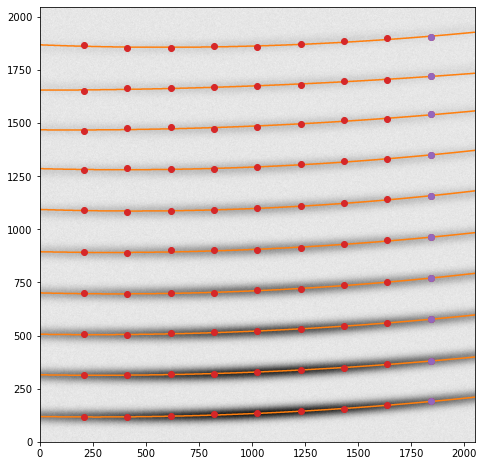

In [8]:
dx = nx//10
n = 4
xselect = np.arange(nx//2-dx*n,nx//2+dx*n+1, dx,dtype=int)

peaks = []
pvals = []
for xind in xselect:
    y=image[:,xind]
    ysm = savgol_filter(y,21,1)
    base = peakutils.baseline(ysm,6)
    ind = peakutils.indexes(ysm-base, thres =.1, min_dist = 180)
    peaks.append(ind)
    pvals.append(ysm[ind])

# check if all peaks were detected
uniques = np.unique([len(i) for i in peaks])
if uniques.shape[0] > 1:
    print("Adjust peak finding parameters,", uniques)
else:
    print("Shape's good!\nBut check the image, did we get everything?")
    pat_y = np.array(peaks)
    # Fit quadratics
    fits = [np.poly1d(np.polyfit(xselect,i,2)) for i in pat_y.T]
    x = np.arange(nx)
    pattern = np.array([f(x) for f in fits],dtype=int)    
    # Plot fits
    [plt.plot(p,'C1') for p in pattern]
    
plt.imshow(image, origin="lower", cmap="binary")  # norm=mpl.colors.LogNorm(image.min(), image.max() * scale))

# Plot peaks
for ind,px in zip(peaks,xselect):
    x = np.ones(ind.shape[0])*px
    plt.plot(x,ind,'oC3')

plt.plot(x,ind,'oC4')


plt.gcf().set_size_inches([8,8])

# Save current image and pattern

In [10]:
if uniques.shape[0] == 1:
    np.savetxt('pattern_image_synthetic.txt',image)
    np.savetxt('pattern.txt',pattern.T,fmt='%.d')